# Persistent Homology for Low Complexity Models
## Code and Examples

The code described requires the external [COIL](http://www.cs.columbia.edu/CAVE/software/softlib/coil-100.php) data set. For the computation of persistent homology, it uses the [Python wrapper](https://ripser.scikit-tda.org/) for [Ripser](https://github.com/Ripser/ripser) and the Python frontend of [GUDHI](http://gudhi.gforge.inria.fr/). The code also uses the [FHT (Fast Hadamard Transform)](https://github.com/FALCONN-LIB/FFHT) package. 

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import numpy.random as rnd
import PIL
import random
import falconn
#import ffht
import timeit
from timeit import default_timer as timer
import ripser
from ripser import Rips, ripser
import gudhi

The following code is a standard implementation, based largely on code by [Ding Luo](https://github.com/dingluo/fwht). This is used because of problems installing the faster ffht package.

In [2]:
def fwht(x):
    """ Fast Walsh-Hadamard Transform, naive implementation
    Based on code by Ding Luo
    """
    N = x.size
    k = int(np.log2(N))
    G = N//2 # Number of Groups
    M = 2 # Number of Members in Each Group

    # First stage
    y = np.zeros((N//2,2))
    y[:,0] = x[0::2] + x[1::2]
    y[:,1] = x[0::2] - x[1::2]
    x = y.copy()
    # Second and further stage
    for i in range(2,k+1):
        y = np.zeros((G//2,M*2))
        y[0:G//2,0:M*2:4] = x[0:G:2,0:M:2] + x[1:G:2,0:M:2]
        y[0:G//2,1:M*2:4] = x[0:G:2,0:M:2] - x[1:G:2,0:M:2]
        y[0:G//2,2:M*2:4] = x[0:G:2,1:M:2] - x[1:G:2,1:M:2]
        y[0:G//2,3:M*2:4] = x[0:G:2,1:M:2] + x[1:G:2,1:M:2]
        x = y.copy()
        G //= 2
        M *= 2
    x = y[0,:]
    x = x.reshape((x.size,1))
    return(x/float(N))

## 1) Performance test for random projections with Fast Hadamard Transform

The aim here is merely to demonstrate that, using a subsampled fast transform, the cost of projecting the data to a lower dimensional space does not outweigh the cost saved in computing pairwise distances in lower dimensions, provided the data set is large enough.

In [3]:
# Parameters
d = 2**12                # data dimension
n = 10**6                # number of data points
step=16                  # increase by ...
reps = 1000              # repetitions for random experiments
X = rnd.randn(d,2*reps)  # random data to compute distances on

In [4]:
# Determine average cost of computing distances between vectors of lengths up to d
# This clearly depends strongly on architecture
costs = np.zeros(d)
for t in range(reps):
    for m in range(1,d):
        t1 = timeit.default_timer()
        v = X[:m,t]-X[:m,reps+t]
        np.dot(v,v)
        t2 = timeit.default_timer()
        costs[m] += t2-t1
costs = costs/reps

In [5]:
# Do a smoothing of the curve (to estimate the slope)
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
costs_smooth = running_mean(costs, 20)

In [6]:
# Compute an idealized version of the computation costs (a linear estimate)
slope = (costs_smooth[4000]-costs_smooth[2600])/1400
intersect = costs_smooth[4000]-slope*4000
def line(x):
    return slope*x+intersect

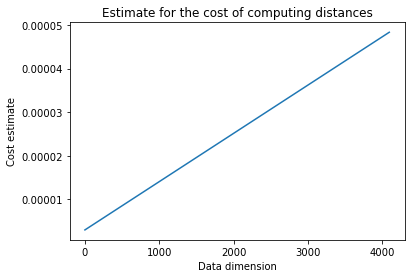

In [7]:
# Just to get an idea...
plt.plot(line(np.arange(1,d)))
plt.xlabel("Data dimension")
plt.ylabel("Cost estimate")
plt.title("Estimate for the cost of computing distances")
plt.show()

In [8]:
# Test the cost of computing the fast hadamard transform
fht_costs = np.zeros(d)
# Get random sign vector
signs = np.array([(-1)**random.randint(0,1) for i in range(d)])
for r in range(reps):
    for m in range(1,13):
        t = timeit.default_timer()
        y = signs[:2**m]*X[:2**m,r]
        x = fwht(y)
        #ffht.fht(y)
        fht_costs[2**m-1] += timeit.default_timer()-t
fht_costs = fht_costs/reps
for m in range(1,13):
    fht_costs[2**(m-1):2**m-1] = fht_costs[2**m-1]

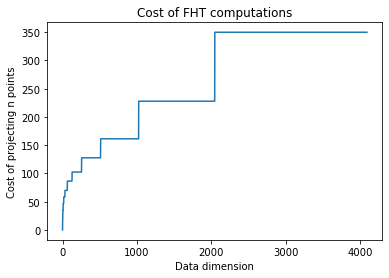

In [9]:
# Plot costs of FHT computation on all data points (to get an idea...)
plt.plot(n*fht_costs)
plt.xlabel("Data dimension")
plt.ylabel("Cost of projecting n points")
plt.title("Cost of FHT computations")
plt.show()

In [10]:
# For each data dimension d and projection dimension m, compute trade-off threshold
# (number of samples when the projection is worth it from a computational complexity perspective)
def n_bound(d,m):
    return 2*fht_costs[d-1]/(slope*(d-m)) + 1

In [11]:
yy = np.array([n_bound(d,i) for i in range(d)])
dd = 256
yy_red = np.array([n_bound(dd,i) for i in range(dd)])

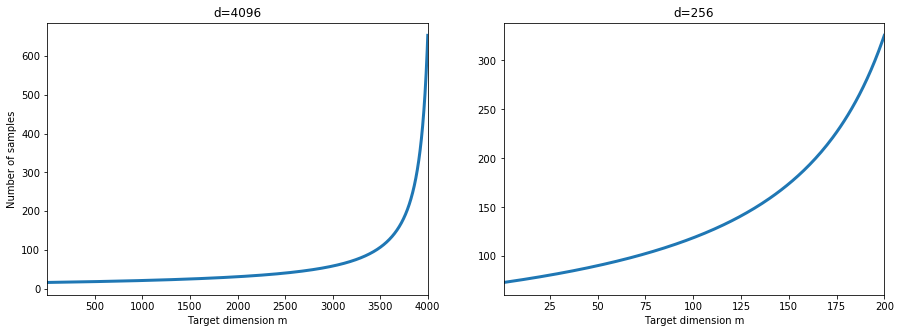

In [12]:
# Plot the three against each other
fig, ax = plt.subplots(1, 2, figsize=(15,5))

xx = np.arange(1,d+1)
ax[0].plot(xx[:4000], yy[:4000], linewidth=3)
ax[0].set_title("d=4096")
ax[0].set_ylabel("Number of samples")
ax[0].set_xlabel("Target dimension m")
ax[0].set_xlim(1,4000)
#ax[0].axis('off')

ax[1].plot(xx[:200], yy_red[:200], linewidth=3)
ax[1].set_title("d=256")
ax[1].set_ylabel("")
ax[1].set_xlim(1,200)
#ax[1].axis('off')
ax[1].set_xlabel("Target dimension m")

plt.savefig("savings.png")

## 2) Persistent Homology computations

In [13]:
N = 7200    # Number of images
d = 128*128 # (effective) size of each image
n = 72      # One image
N,d,d*N,d*n

(7200, 16384, 117964800, 1179648)

In [14]:
num_objs = 20 # number of objects to consider
img_per_obj = 72
X = np.zeros((d,3,img_per_obj*num_objs))
for i in range(num_objs):
    for j in range(img_per_obj):
        U = np.array(PIL.Image.open("data/coil-100/obj"+str(i+1)+"__"+str(5*j)+'.png')).reshape((d,3))
        X[:,:,i*img_per_obj+j] = U
X.shape

(16384, 3, 1440)

In [15]:
# Get one color of all images
Y  = X[:,0,13*n:13*n+n]
Y = Y/np.max(Y)
np.shape(Y)

(16384, 72)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


C:\ProgramData\Anaconda3\lib\site-packages\ripser\ripser.py:221: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  + "did you mean to transpose?"


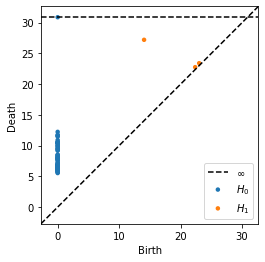

In [16]:
# Compute persistence diagram using ripser
r = Rips()
rips_diagram = ripser(Y.transpose())['dgms']
rips_diagram_log = np.log(rips_diagram[1])
r.plot(rips_diagram, show=True)

In [17]:
# Compute persistent homology with GUDHI
reps = 200
stepl = 10
failcounter = 0
upperbound = 400
fails = reps*np.ones(int(upperbound/stepl))
for i,m in enumerate(range(stepl,upperbound,stepl)):
    failcounter=0
    ratio = 1/np.sqrt(m)
    print(m)
    for t in range(reps):
        # Compute reduction using Gaussian matrices here
        G = ratio*rnd.randn(m,d)
        PY = np.dot(G,Y).transpose()
        rips_complex_red = gudhi.RipsComplex(points=PY)
        simplex_tree_red = rips_complex_red.create_simplex_tree(max_dimension=2)
        p_red = simplex_tree_red.persistence()
        rips_diagram_red = np.log(simplex_tree_red.persistence_intervals_in_dimension(1))
        bottle = np.exp(gudhi.bottleneck_distance(rips_diagram_log, rips_diagram_red))
        epsilon = 1-bottle
        if np.abs(epsilon)>0.1:
            failcounter += 1
    fails[i] = failcounter
fails = fails/reps

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


In [18]:
U = np.array(PIL.Image.open("data/coil-100/obj14__0.png"))

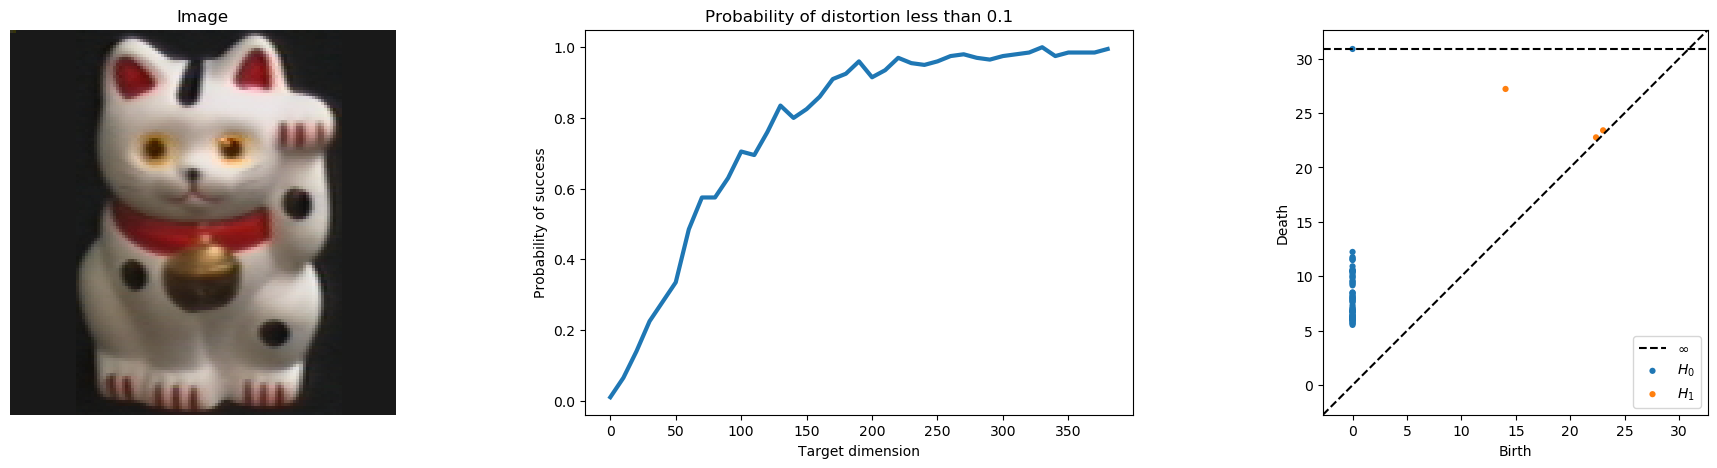

In [19]:
# Plot the three against each other
fig, ax = plt.subplots(1, 3, figsize=(24,5))

ax[0].imshow(U)
ax[0].set_title("Image")
ax[0].axis('off')

ax[1].plot(1-fails[:-1], linewidth='3')
ax[1].set_xlabel("Target dimension")
ax[1].set_ylabel("Probability of success")
ax[1].set_title("Probability of distortion less than 0.1")
ax[1].set_xticklabels(('','0','50','100','150','200','250','300','350'))

ax[2] = r.plot(rips_diagram, show=True)
plt.show()
#plt.savefig("coilexp.png")